# Writeup Template

You can use this file as a template for your writeup if you want to submit it as a markdown file, but feel free to use some other method and submit a pdf if you prefer.

Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

Rubric Points : https://review.udacity.com/#!/rubrics/513/view



## 0. Bring Dataset 

In [0]:
# bring test list
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage.measurements import label
import cv2
import glob
import os
import time
from collections import deque
from sklearn.utils import shuffle 
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle


%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

cars = []
notcars = []
allfile = 0

for root ,dirs, files in os.walk('dataset'):
    for f in files:
        f = root + '\\'+ f
        allfile += 1
        if not f.endswith(".png"):
            continue
        if f.find('non-vehicle') != -1: # if find vehicle
            notcars.append(f)
        else : 
            cars.append(f)
            
    

print("cars:",cars[1],"len:",len(cars))
print("notcars:",notcars[1],"len:",len(notcars))
print(len(cars) + len(notcars))
print(allfile)

cars: dataset\vehicles\GTI_Far\image0001.png len: 8792
notcars: dataset\non-vehicles\Extras\extra10.png len: 8968
17760
17769


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


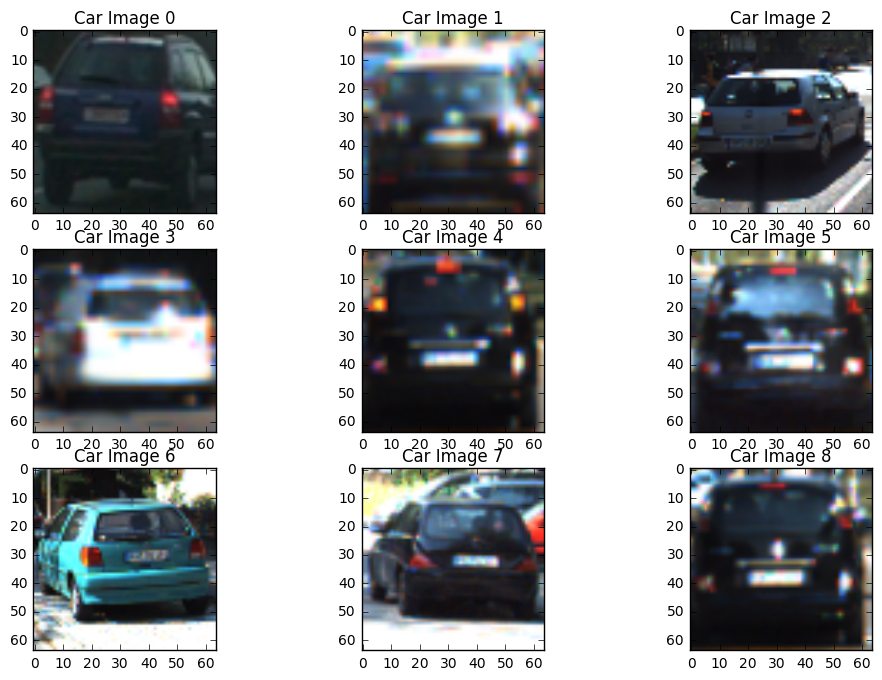

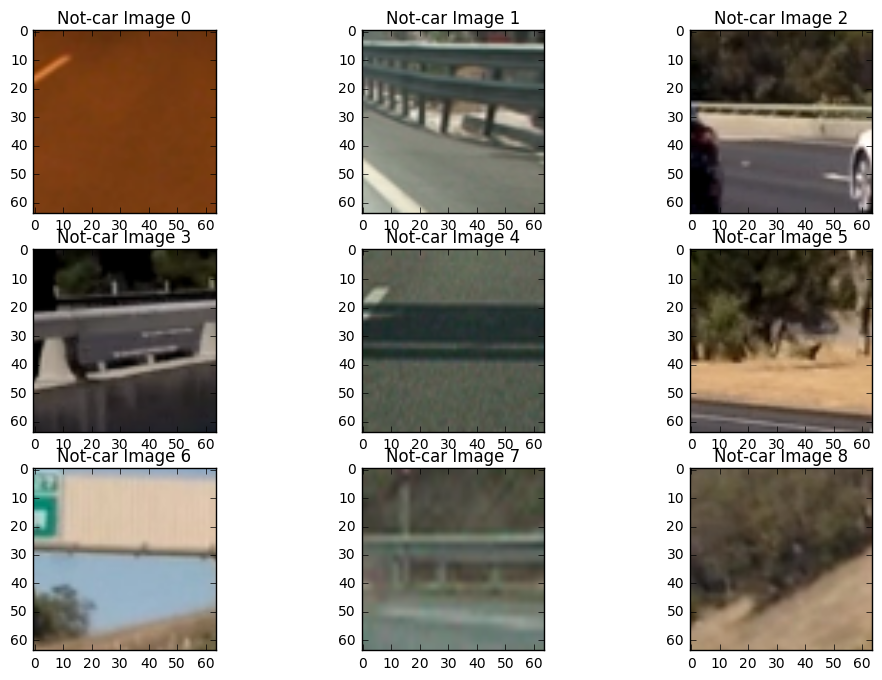

In [0]:
 
# Define a  function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = 0
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = 0
    for car in car_list:
        data_dict["n_cars"] += 1
    for notcar in notcar_list:
        data_dict["n_notcars"] += 1
    
    # Read in a test image, either car or notcar
    img = cv2.imread(cars[0])
    
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images
car_inds = []
notcar_inds = []

plt.figure(figsize=(12, 8))

# Plot the examples
for i in range(9):
    car_ind = np.random.randint(0, len(cars))
    car_image = mpimg.imread(cars[car_ind])
    #fig = plt.figure(figsize=(15,7))
    plt.subplot(331+i)
    plt.imshow(car_image)
    plt.title('Car Image {}'.format(i))
plt.show()

plt.figure(figsize=(12, 8))

for i in range(9):
    notcar_ind = np.random.randint(0, len(notcars))
    notcar_image = mpimg.imread(notcars[notcar_ind])
    plt.subplot(331+i)
    plt.imshow(notcar_image)
    plt.title('Not-car Image {}'.format(i))
plt.show()

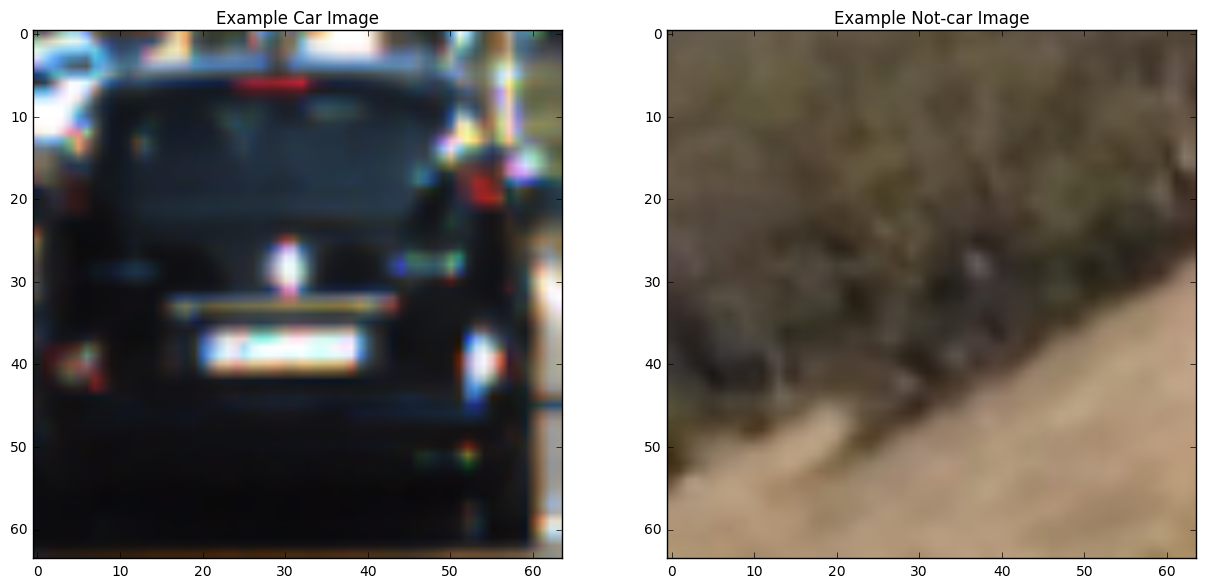

In [0]:
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure(figsize=(15,7))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [0]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='HSV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## 1. Histogram of Oriented Gradients (HOG)

### 1.1 Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

I use scikit-image library. it hads a built in fuction to extract Histogram of Oriented Gradient(HOG) features. We can load the hog fuction from scikit-image library.
```python
from skimage.feature import hog
```
[This site](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) explain about the hog function. It extracts features like bellow. HOG feature descriptor is popular for object detection.

<img src="http://scikit-image.org/docs/dev/_images/sphx_glr_plot_hog_001.png">

Hog function use parameters as orientations, pixels_per_cell and cells_per_block. And I use all channels on final training. The result is better than a channel.

|parameters|value|explain|
|----|----|----|
|orientations|9|The number of orientations is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.|
| pixels_per_cell|8|The pixels_per_cell parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.|
|cells_per_block|2|The cells_per_block parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.|

<img src="https://d17h27t6h515a5.cloudfront.net/topher/2016/December/585b6011_hog-visualization/hog-visualization.jpg" width=600>

Reference by [20. scikit-image Hog Udacity lecture ](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/d479f43a-7bbb-4de7-9452-f6b991ece599)


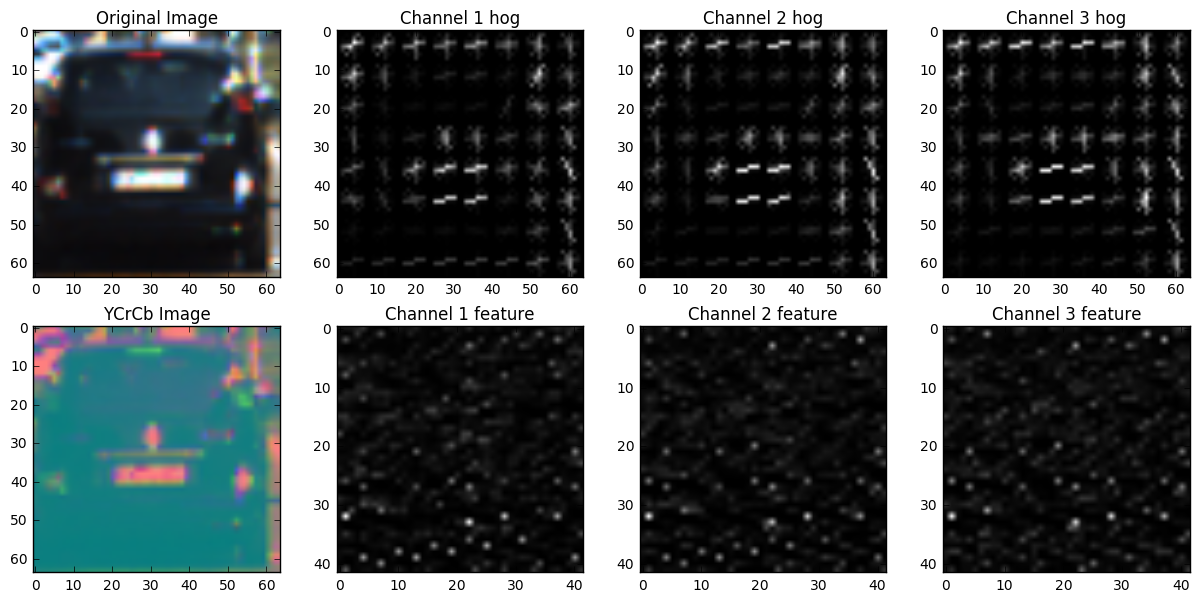

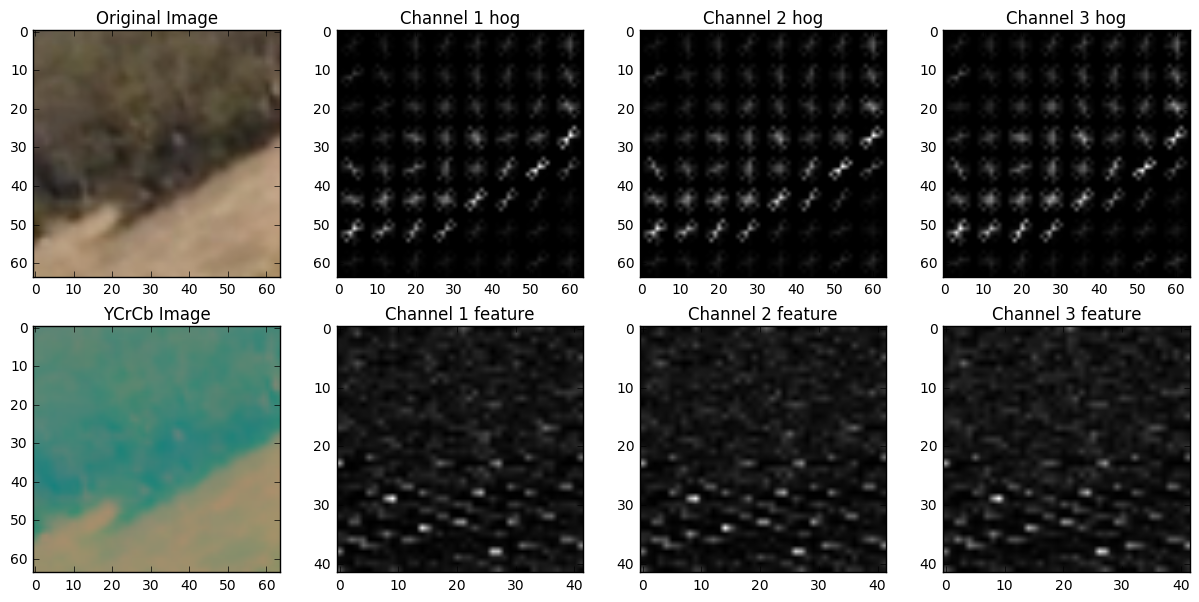

In [0]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

def plot_hog_figures(image):
    fig, axes = plt.subplots(2,4,figsize=(15,7))
    
    for i in range(2):
        axes[0,0].imshow(image)
        axes[0,0].set_title('Original Image') # 0:R 1:G 2:B
        
        cvt_image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
        axes[1,0].imshow(cvt_image,'gray')
        axes[1,0].set_title('YCrCb Image') # 0:R 1:G 2:B
        
        for channel in range(3):
            features, hog_image = get_hog_features(image[:,:,channel],
                                             orient, pix_per_cell, cell_per_block,
                                             vis=True, feature_vec=True)
            if i == 0 :
                title = "hog"
                temp = hog_image
            else :
                title = "feature"
                temp = np.array(features.reshape(42,42))
                
            
            axes[i,channel+1].imshow(temp,'gray')
            axes[i,channel+1].set_title('Channel {} {}'.format(channel+1,title)) # 0:R 1:G 2:B
    plt.show()
        
plot_hog_figures(car_image)
plot_hog_figures(notcar_image)

### 1.2 Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

The HOG features extracted from the training data have been used to train a classifier, could be SVM, Decision Tree or other. Features should be scaled to zero mean and unit variance before training the classifier.

> I tested all channels and color spaces. All Channels is the best in most cases.

In [0]:
def train_svc(colorspace='YCrCb',orient=9,pix_per_cell=8,cell_per_block=2,hog_channel=0):
    t=time.time()
    car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
    notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    
    # Use a linear SVC 
    svc = LinearSVC(C=10.)
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    score = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', score)
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return svc, score, X_scaler

In [0]:
colorspace = 'RGB'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"

t=time.time()
car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
    
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
    
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print("Start gridsearchcv")
# Use a linear SVC 
svc = LinearSVC()
param_grid = [{'C': [1, 10, 100, 1000]} ]
clf = GridSearchCV(svc, param_grid)
clf.fit(X_train, y_train)
clf

77.88 Seconds to extract HOG features...
Start gridsearchcv


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 10, 100, 1000]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [0]:
pd.DataFrame(clf.cv_results_).T

0           1           2            3
mean_fit_time          24.9748     8.19812     8.00427      7.58449
mean_score_time       0.131015    0.063837   0.0651739    0.0671789
mean_test_score       0.977407    0.977407    0.977407     0.977407
mean_train_score             1           1           1            1
param_C                      1          10         100         1000
params                {'C': 1}   {'C': 10}  {'C': 100}  {'C': 1000}
rank_test_score              1           1           1            1
split0_test_score     0.979312    0.979312    0.979312     0.979312
split0_train_score           1           1           1            1
split1_test_score     0.975296    0.975296    0.975296     0.975296
split1_train_score           1           1           1            1
split2_test_score     0.977614    0.977614    0.977614     0.977614
split2_train_score           1           1           1            1
std_fit_time           5.64766    0.550865    0.834103     0.221805
std_score_time       0.0903706  0.00603408  0.00727606   0.00708983
std_test_score      0.00164617  0.00164617  0.00164617   0.00164617
std_train_score              0           0           0            0

In [0]:
### TODO: Tweak these parameters and see how the results change.
result = {}

for colorspace in ['HLS', 'YUV', 'YCrCb', 'RGB', 'HSV', 'LUV']:
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channels_result = {}
    
    for hog_channel in [0, 1, 2, "ALL"]:
        
        try:
            svc, score, X_scaler = train_svc(colorspace,orient=9,pix_per_cell=8,cell_per_block=2,hog_channel=hog_channel)
            hog_channels_result[hog_channel] = score
            
        except Exception as e:
            print(e)
    
    result[colorspace] = hog_channels_result

82.98 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
22.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9538
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
0.00401 Seconds to predict 10 labels with SVC
92.51 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
7.59 Seconds to train SVC...
Test Accuracy of SVC =  0.982
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
0.00103 Seconds to predict 10 labels with SVC
69.69 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
19.39 Seconds to train SVC...
Test Accuracy of SVC =  0.9544
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 1.

In [0]:
result_df = pd.DataFrame(result)
result_df.T

# {'HSV': 0.93999999999999995, 'LUV': 0.93999999999999995, 'RGB': 0.94499999999999995}
# {'YCrCb': 0.96999999999999997, 'YUV': 0.92500000000000004, 'HLS': 0.92500000000000004}

0       1       2     ALL
HLS    0.9538  0.9820  0.9544  0.9918
HSV    0.9592  0.9640  0.9792  0.9918
LUV    0.9789     NaN     NaN     NaN
RGB    0.9707  0.9747  0.9744  0.9806
YCrCb  0.9772  0.9581  0.9566  0.9893
YUV    0.9747  0.9592     NaN     NaN

## 2. Sliding Window Search

### Bring test images

### Retrain

In [0]:
### TODO: Tweak these parameters and see how the results change.
svc, score, X_scaler = train_svc(colorspace='YCrCb',orient=9,pix_per_cell=8,cell_per_block=2,hog_channel='ALL')

94.84 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
20.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9873
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
0.00752 Seconds to predict 10 labels with SVC


## save the svc

In [0]:
# save the classifier
with open('my_dumped_classifier.pkl', 'wb') as f:
    pickle.dump([svc, X_scaler], f)
    
print(type(svc), type(X_scaler))

<class 'sklearn.svm.classes.LinearSVC'> <class 'sklearn.preprocessing.data.StandardScaler'>


##  load the svc

In [0]:
# load the classifier
with open('my_dumped_classifier.pkl', 'rb') as f:
    svc, X_scaler = pickle.load(f)
    
print(type(svc), type(X_scaler))

<class 'sklearn.svm.classes.LinearSVC'> <class 'sklearn.preprocessing.data.StandardScaler'>


In [0]:
test_image_list = []

for root, dirs, files in os.walk("test_images"):
    for f in files:
        f = root + "/" + f
        if f.endswith("jpg") :
            test_image_list.append(f)
            
print (test_image_list)

['test_images/test.jpg', 'test_images/test0.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg', 'test_images/test7.jpg']


### 2.1 Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

A sliding window approach has been implemented, where overlapping tiles in each test image are classified as vehicle or non-vehicle. Some justification has been given for the particular implementation chosen.


### 2.2 Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

Some discussion is given around how you improved the reliability of the classifier i.e., fewer false positives and more reliable car detections (this could be things like choice of feature vector, thresholding the decision function, hard negative mining etc.)

> This detector sometimes falsifies the image. So we use heatmap. A lot of windows is overlapped. If one point is detected in many cases, this is very likely to be properly detected. At first, draw a heatmap and apply a threshold.

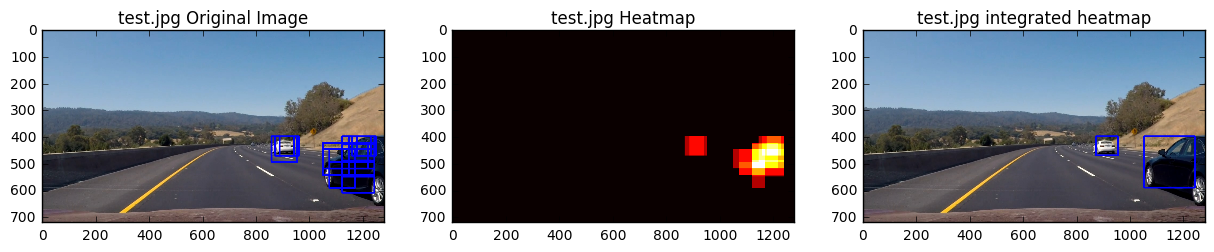

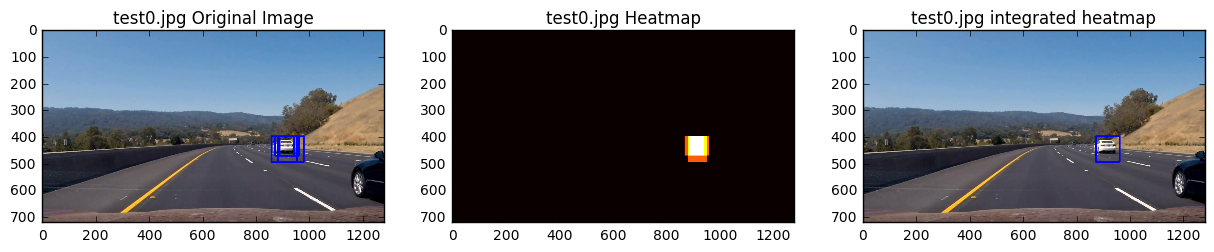

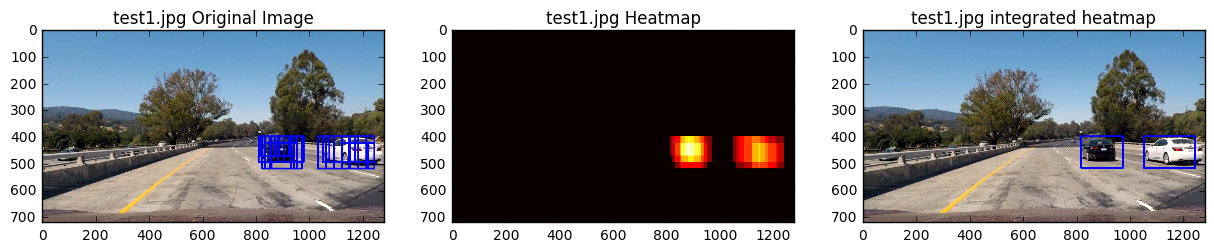

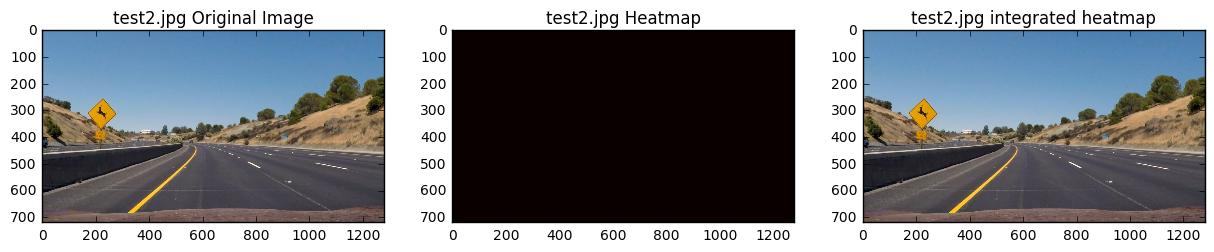

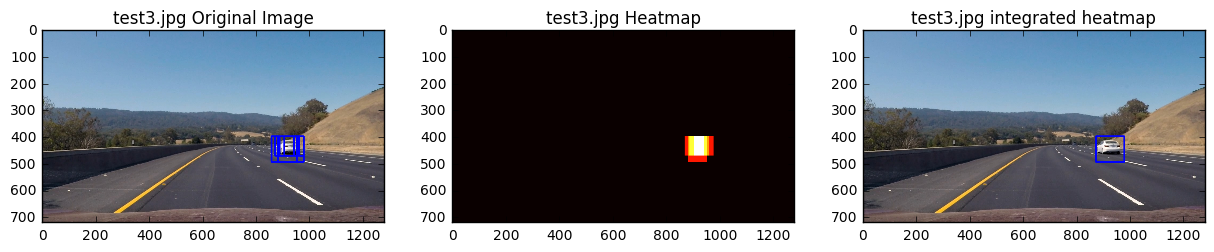

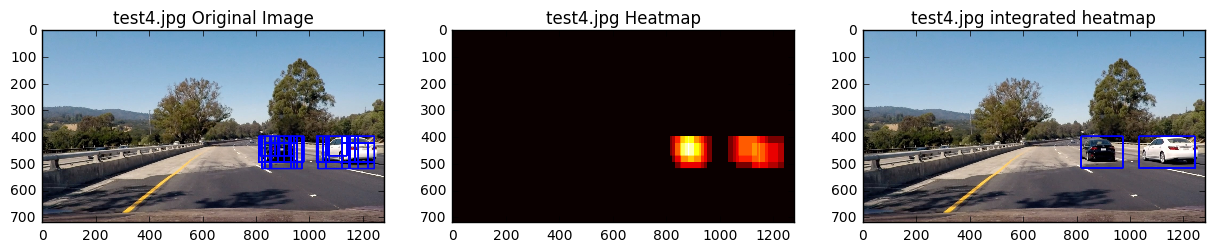

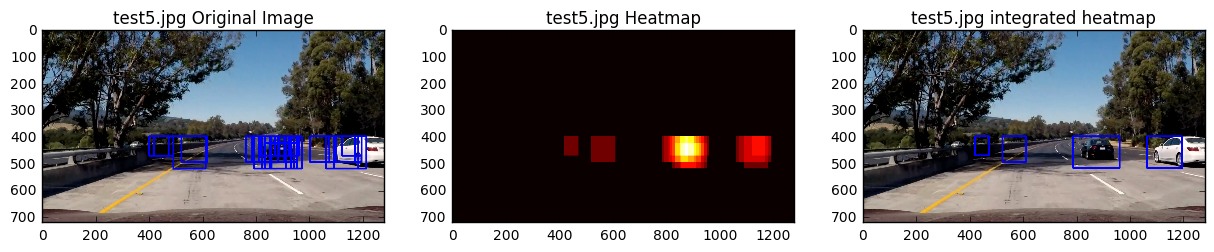

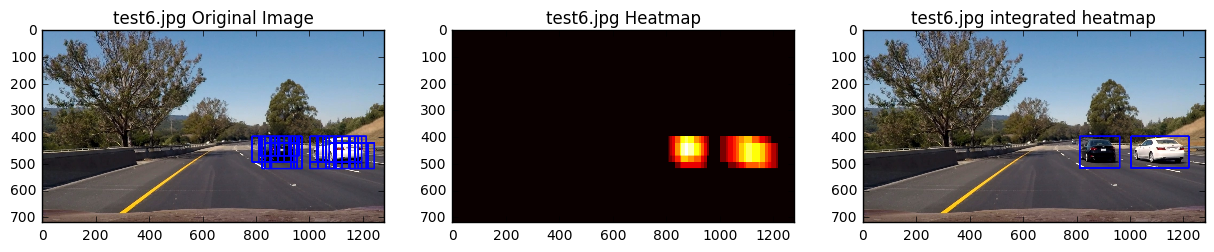

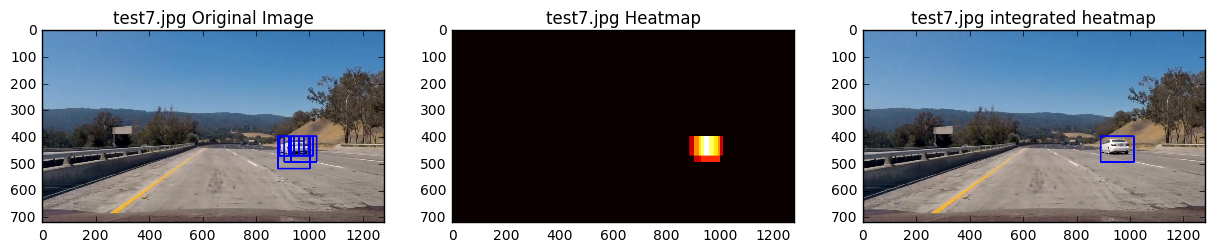

In [0]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 8*pix_per_cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = (xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)
                cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6) 
                boxes.append(box)
    
    return boxes

def draw_heat(img, box_list):
    # heatmap
    heat = np.zeros_like(img[:,:,0]).astype(np.float)            
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    return heatmap

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

xstart = 400
xstop = 1280

ystart = 400
ystop = 656
scale = 1.5

orient = 9
pix_per_cell = 8 
cell_per_block = 2 
spatial_size = (32, 32) 
hist_bins = 32
window = 64

for f in test_image_list:
    img = mpimg.imread(f)
    
    boxes = []
    boxes += find_cars(img, xstart, xstop, 400, 656, scale, svc, X_scaler, orient, 8, cell_per_block, spatial_size, hist_bins)
    boxes += find_cars(img, xstart, xstop, 400, 500, scale, svc, X_scaler, orient, 6, cell_per_block, spatial_size, hist_bins)
    boxes += find_cars(img, xstart, xstop, 400, 656, scale, svc, X_scaler, orient, 10, cell_per_block, spatial_size, hist_bins)
    
    draw_img = draw_boxes(img, boxes, color=(0, 0, 255), thick=6)
    
    heatmap = draw_heat(img, boxes)
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(img), labels)
    
    fn = f.split("/")[-1]
    fig = plt.figure(figsize=(15,7))
    plt.subplot(131)
    plt.imshow(draw_img)
    plt.title('{} Original Image'.format(fn))
    plt.subplot(132)
    plt.imshow(heatmap, 'hot')
    plt.title('{} Heatmap'.format(fn))
    plt.subplot(133)
    plt.imshow(result)
    plt.title('{} integrated heatmap'.format(fn))
    plt.show()

## 3. Video Implementation

### 3.1 Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

The sliding-window search plus classifier has been used to search for and identify vehicles in the videos provided. Video output has been generated with detected vehicle positions drawn (bounding boxes, circles, cubes, etc.) on each frame of video.

### 3.2 Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

A method, such as requiring that a detection be found at or near the same position in several subsequent frames, (could be a heat map showing the location of repeat detections) is implemented as a means of rejecting false positives, and this demonstrably reduces the number of false positives. Same or similar method used to draw bounding boxes (or circles, cubes, etc.) around high-confidence detections where multiple overlapping detections occur.

In [0]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

history = deque(maxlen = 8)

def process_image(img, threshold=1):
    boxes = []
    boxes += find_cars(img, xstart, xstop, 400, 656, scale, svc, X_scaler, orient, 
                                8, cell_per_block, spatial_size, hist_bins)
    boxes += find_cars(img, xstart, xstop, 400, 500, scale, svc, X_scaler, orient, 
                                6, cell_per_block, spatial_size, hist_bins)
    boxes += find_cars(img, xstart, xstop, 400, 656, scale, svc, X_scaler, orient, 
                                10, cell_per_block, spatial_size, hist_bins)
    
    draw_img = draw_boxes(img, boxes, color=(0, 0, 255), thick=6)
    
    heatmap = draw_heat(img, boxes)
    
    history.append(heatmap)
    history_average = np.average(history, axis=0)
    history_average[history_average <= threshold] = 0
    
    labels = label(history_average)
    result = draw_labeled_bboxes(np.copy(img), labels)
    
    return result

white_output = 'convert_test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video convert_test_video.mp4
[MoviePy] Writing video convert_test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:18<00:00,  2.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: convert_test_video.mp4 

Wall time: 22.4 s


In [0]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

history = deque(maxlen = 8)

white_output = 'convert_project_video.mp4'
clip2 = VideoFileClip("project_video.mp4")
white_clip = clip2.fl_image(process_image)#.subclip(40,50) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video convert_project_video.mp4
[MoviePy] Writing video convert_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [12:49<00:00,  1.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: convert_project_video.mp4 

Wall time: 12min 50s


## 4. Discussion

### 4.1 Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

### 4.2 Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail.

Like P4, it can be mistakenly recognized in case of shadows, trees, people, objects with a lot of noise. Remove noise as much as possible and add more notcar data. In addition, it is extremely rare for a vehicle to appear suddenly, so it is possible to record past values and apply appropriate algorithm values to minimize the sudden change in value. If it is difficult to handle false positives, it may be a good idea to display a window of another color that offers a possibility.
